In [1]:
#Importing dependencies

import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#tensorflow dependencies- Functional API

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input


In [3]:
#Creating folder structures

POS_PATH= '/content/drive/MyDrive/face-detection/data/positive'
NEG_PATH= '/content/drive/MyDrive/face-detection/data/negative'
ANC_PATH= '/content/drive/MyDrive/face-detection/data/anchor'


In [4]:
anchor= tf.data.Dataset.list_files(ANC_PATH+ '/*.jpg').take(3000)  #\* indidcating to grab everything in the jpg format
positive= tf.data.Dataset.list_files(POS_PATH+ '/*.jpg').take(3000)
negative= tf.data.Dataset.list_files(NEG_PATH+ '/*.jpg').take(3000)

In [5]:
def preprocessing(file_path):
    
    byte_img= tf.io.read_file(file_path)
    img= tf.io.decode_jpeg(byte_img)
    img= tf.image.resize(img, (100,100))
    img= img/255.0
    return img

In [6]:
positives= tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) #creating the input tuple
negatives= tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data= positives.concatenate(negatives)

In [7]:
def process(test_img, val_img, label):
    return (preprocessing(test_img), preprocessing(val_img), label)

In [8]:
#building dataloader pipeline

data= data.map(process)
data= data.cache()
data= data.shuffle(buffer_size=10000)

In [9]:
#creating train partition

train_data= data.take(round(len(data) *.7))
train_data= train_data.batch(16)
train_data= train_data.prefetch(8)

In [10]:
#creating testing partition

test_data= data.skip(round(len(data) *.7))
test_data= test_data.take(round(len(data) * .3))
test_data= test_data.batch(16)
test_data= test_data.prefetch(8)

In [11]:
def make_embedding():
    
    inp= Input(shape= (100,100,3), name='input_image')
    
    #first block
    c1= Conv2D(64, (10,10), activation= 'relu')(inp)
    m1= MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #second block
    c2= Conv2D(128, (7,7), activation= 'relu')(m1)
    m2= MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #third block
    c3= Conv2D(128, (4,4), activation= 'relu')(m2)
    m3= MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #final embedding block
    c4= Conv2D(256, (4,4), activation='relu')(m3)
    f1= Flatten()(c4)
    d1= Dense(4096, activation= 'sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1] , name='embedding')

In [12]:
embedding= make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [13]:
#siamese L1 distance class

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [14]:
def make_siamese_model():
    
    #anchor image input in the network
    input_image= Input(name='input_img', shape=(100,100,3))
    
    #validation image in the network
    validation_image= Input(name='validation_img', shape= (100,100,3))
    
    #combining siamese distance components
    siamese_layer= L1Dist()
    siamese_layer._name= 'distance'
    distances= siamese_layer(embedding(input_image), embedding(validation_image))
    
    #classification layer
    classifier= Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs= [input_image, validation_image], outputs= classifier, name='SiameseNetwork')

In [15]:
siamese_model= make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [16]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [17]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [18]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
       

In [19]:
EPOCHS=20
train(train_data, EPOCHS)

Streaming output truncated to the last 5000 lines.
263/263 [==============================] - 81s 309ms/step
0.0002864219 0.9858156 0.9980852

 Epoch 3/20
263/263 [==============================] - 81s 307ms/step
0.01733492 0.98892635 0.9995134

 Epoch 4/20
263/263 [==============================] - 82s 310ms/step
0.056854807 0.99047166 0.99903893

 Epoch 5/20
263/263 [==============================] - 80s 306ms/step
0.015766611 0.9929841 1.0

 Epoch 6/20
263/263 [==============================] - 79s 301ms/step
0.021224359 0.9636885 0.9965415

 Epoch 7/20
263/263 [==============================] - 80s 304ms/step
0.01346375 0.9971014 1.0

 Epoch 8/20
263/263 [==============================] - 77s 291ms/step
0.0038752249 0.9980714 1.0

 Epoch 9/20
263/263 [==============================] - 78s 293ms/step
0.023056371 0.99670744 1.0

 Epoch 10/20
263/263 [==============================] - 79s 300ms/step
0.10472368 0.99810517 0.9995256

 Epoch 11/20
263/263 [==============================]

In [20]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [21]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 21ms/step


In [22]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1]

In [23]:
y_true

array([1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

In [24]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [25]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [26]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 21ms/step
1.0 1.0


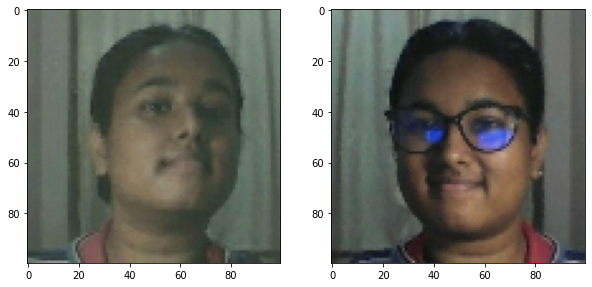

In [27]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [28]:
# Save weights
siamese_model.save('siamesemodelv2.h5')